In [8]:
from keras.src.metrics.metrics_utils import confusion_matrix
%load_ext autoreload
%autoreload 2

import torch
import matplotlib

import numpy as np
import diveslowlearnfast as dlf
import matplotlib.pyplot as plt
import tools.visualise as viz

from diveslowlearnfast.train import StatsDB

from diveslowlearnfast.train.stats import get_value, get_tuple, get_column, get_dict, get_df


matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading `stats.db`

In [2]:
stats = StatsDB('stats.db')

run_id1, run_id2 = stats.execute_query('SELECT DISTINCT(run_id) FROM stats', extractor=get_tuple)
run_id1, run_id2

('/home/s2871513/Projects/diveslowlearnfast/results/run22',
 '/home/s2871513/Projects/diveslowlearnfast/results/run32')

In [3]:
stats.execute_query('SELECT DISTINCT epoch, run_id FROM stats WHERE split = "test"')

[[20, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [30, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [40, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [50, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [60, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [70, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [80, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [90, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [100, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [110, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [120, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [130, '/home/s2871513/Projects/diveslowlearnfast/results/run22'],
 [140, '/home/s2871513/Projects/diveslowlearnfast/results/run32'],
 [150, '/home/s2871513/Projects/diveslowlearnfast/results/run32'],
 [160, '/home/s2871513/Projects/diveslowlearnfast/results/run32'],
 [1

In [5]:
start_epoch = stats.execute_query('SELECT MAX(epoch) FROM stats WHERE split = "train" AND run_id = ?', run_id1, extractor=get_value)
start_epoch

133

## Main Analysis

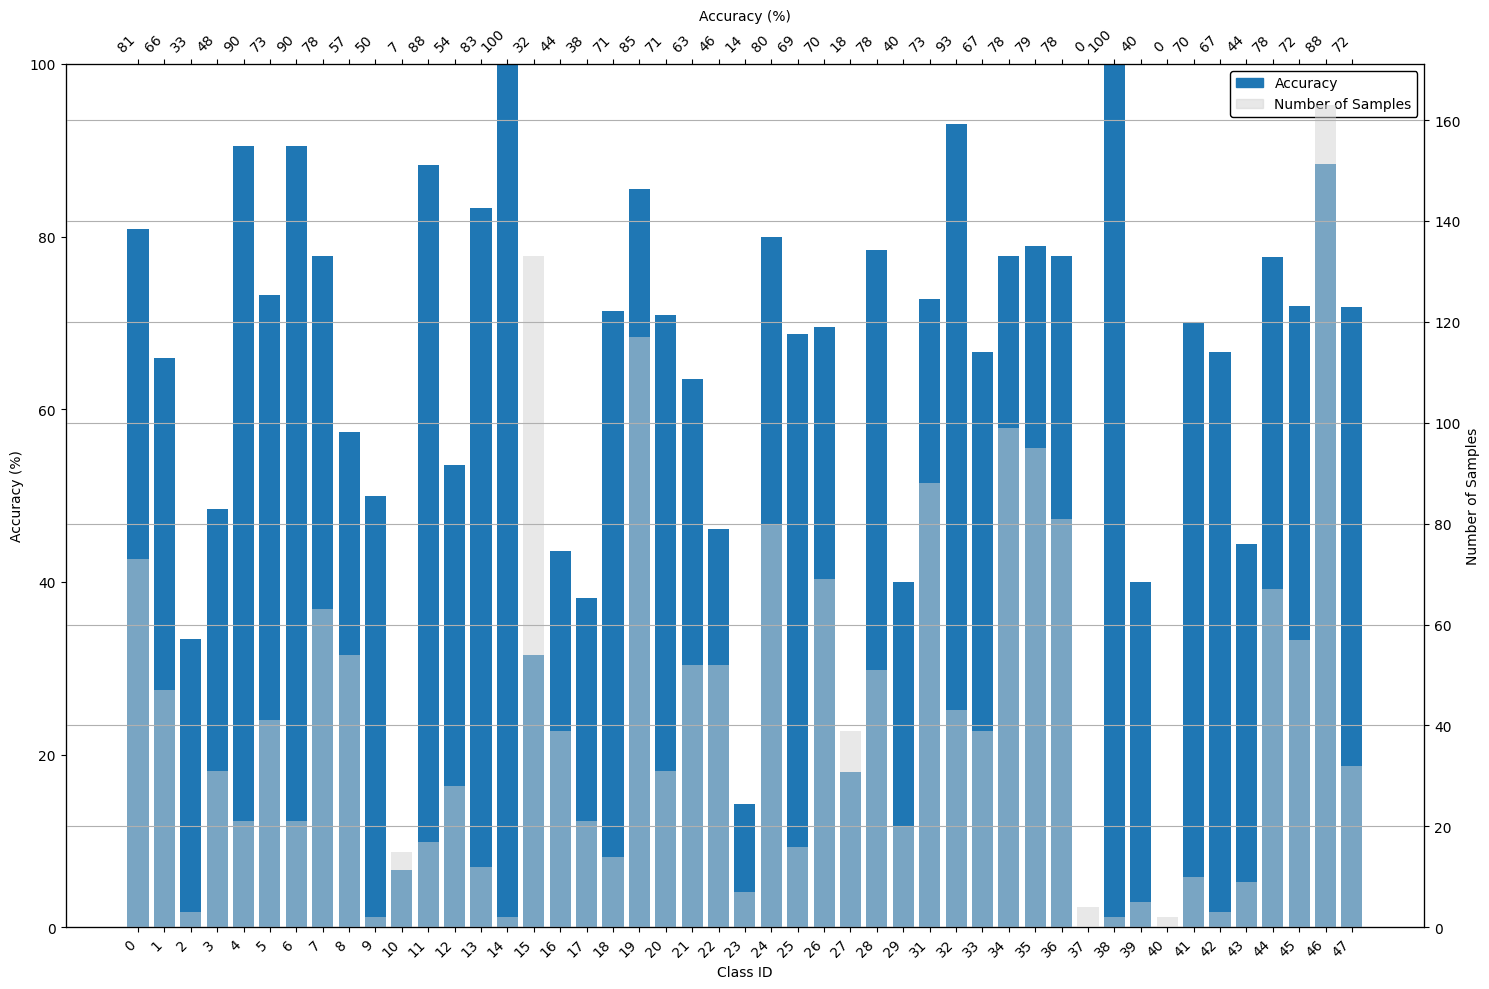

In [6]:
matrix, labels = stats.confusion_matrix(140, run_id2, 'test')

viz.plot_per_class_accuracy(matrix, labels=labels)

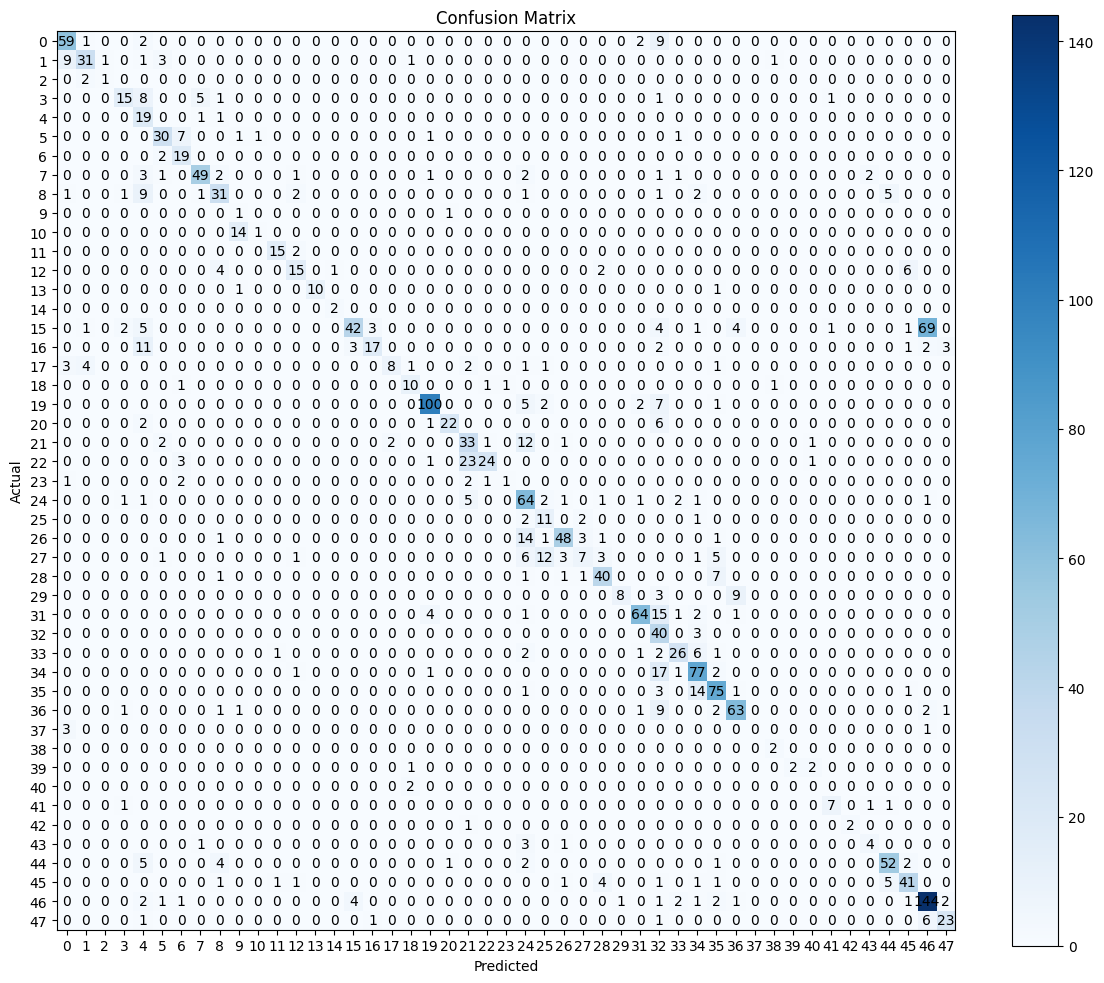

In [7]:
viz.plot_confusion_matrix(matrix, labels=labels)

In [196]:
result_df = stats.get_lowest_percentile(
    start_epoch - 10,
    run_id1,
    'train',
    extractor=get_df
)
masked_video_ids = result_df['video_id']

len(masked_video_ids)

751

In [213]:
before_egl_df = stats.execute_query(f"""SELECT
video_id,
gt,
pred,
CASE WHEN pred = gt THEN 1 ELSE 0 END as correct
FROM stats
WHERE epoch = ?
AND split = "train"
AND run_id = ?
AND video_id IN ({','.join(['?'] * len(masked_video_ids))})
""", 130, run_id1, *masked_video_ids, extractor=get_df)

acc_before = before_egl_df['correct'].sum() / len(before_egl_df)

acc_before

0.6338215712383488

In [215]:
after_egl_df = stats.execute_query(f"""SELECT
video_id,
gt,
pred,
CASE WHEN pred = gt THEN 1 ELSE 0 END as correct
FROM stats
WHERE epoch = ?
AND split = "train"
AND run_id = ?
AND video_id IN ({','.join(['?'] * len(masked_video_ids))})
""", 190, run_id2, *masked_video_ids, extractor=get_df)

acc_after = after_egl_df['correct'].sum() / len(after_egl_df)
acc_after, (acc_after - acc_before)

(0.8229027962716379, 0.18908122503328906)

In [216]:
before_egl_df = stats.execute_query(f"""SELECT
video_id,
gt,
pred,
CASE WHEN pred = gt THEN 1 ELSE 0 END as correct
FROM stats
WHERE epoch = ?
AND split = "train"
AND run_id = ?
AND video_id NOT IN ({','.join(['?'] * len(masked_video_ids))})
""", 130, run_id1, *masked_video_ids, extractor=get_df)

acc_before = before_egl_df['correct'].sum() / len(before_egl_df)

acc_before

0.9412300364247689

In [217]:
after_egl_df = stats.execute_query(f"""SELECT
video_id,
gt,
pred,
CASE WHEN pred = gt THEN 1 ELSE 0 END as correct
FROM stats
WHERE epoch = ?
AND split = "train"
AND run_id = ?
AND video_id NOT IN ({','.join(['?'] * len(masked_video_ids))})
""", 190, run_id2, *masked_video_ids, extractor=get_df)

acc_after = after_egl_df['correct'].sum() / len(after_egl_df)
acc_after, (acc_after - acc_before)

(0.9373073690109275, -0.003922667413841396)

## Mean example improvement after EGL
Here we take a look at the change in performance collected over the last 10 epochs before the intervention and after the intervention.

In [200]:
def accuracy_per_video(run_id, epoch, video_ids, split='train', not_in=False):
    if not_in:
        not_in = 'NOT'
    else:
        not_in = ''
    return stats.execute_query(f"""SELECT video_id, (correct_n / n) as acc  FROM(
            SELECT
                video_id,
                gt,
                epoch,
                split,
                CAST(SUM(CASE WHEN pred = gt THEN 1 ELSE 0 END) as REAL) as correct_n,
                CAST(COUNT(*) as REAL) as n
            FROM stats
            WHERE epoch > ?
            AND video_id {not_in} IN ({','.join(['?'] * len(video_ids))})
            AND run_id = ?
            AND split = ?
            GROUP BY video_id, gt
        ) ORDER BY correct_n
        """,
    epoch,
    *video_ids,
    run_id,
    split,
    extractor=get_df)

In [201]:
before_egl_df = accuracy_per_video(run_id1, start_epoch-10, masked_video_ids)
after_egl_df = accuracy_per_video(run_id2, 185, masked_video_ids)

In [202]:
before_egl_df.head(3)

,video_id,acc
0,_lmT4WlK7G0_00012,0.100000
1,VNvb5oLOpLg_00296,0.200000
2,D8YKHC5hmUs_00034,0.333333


In [95]:
combined_df = before_egl_df.merge(after_egl_df, on='video_id', how='inner')
combined_df.rename(columns={'acc_x': 'acc_before'}, inplace=True)
combined_df.rename(columns={'acc_y': 'acc_after'}, inplace=True)
combined_df.head(7)

,video_id,acc_before,acc_after
0,_lmT4WlK7G0_00012,0.100000,0.1
1,VNvb5oLOpLg_00296,0.200000,0.4
2,D8YKHC5hmUs_00034,0.333333,0.8
3,k1F4LHeYhBs_00207,0.300000,0.4
4,vlfy4cny75s_00070,0.300000,0.8
5,zYHstCxnAPA_00328,0.300000,0.2
6,2x00lRzlTVQ_00096,0.444444,0.5


In [96]:
combined_df['change'] = combined_df['acc_after'] - combined_df['acc_before']
combined_df

,video_id,acc_before,acc_after,change
0,_lmT4WlK7G0_00012,0.100000,0.1,0.000000
1,VNvb5oLOpLg_00296,0.200000,0.4,0.200000
2,D8YKHC5hmUs_00034,0.333333,0.8,0.466667
3,k1F4LHeYhBs_00207,0.300000,0.4,0.100000
4,vlfy4cny75s_00070,0.300000,0.8,0.500000
...,...,...,...,...
746,sk8TafuB3lU_00078,0.700000,0.9,0.200000
747,sk8TafuB3lU_00130,0.700000,0.8,0.100000
748,sk8TafuB3lU_00133,0.700000,0.9,0.200000
749,sk8TafuB3lU_00136,0.700000,0.7,0.000000


In [97]:
combined_df['change'].mean() * 100

10.332889480692414

In [98]:
before_egl_df = accuracy_per_video(run_id1, start_epoch-10, masked_video_ids, not_in=True)
after_egl_df = accuracy_per_video(run_id2, 185, masked_video_ids, not_in=True)

In [99]:
before_egl_df

,video_id,acc
0,-mmq0PT-u8k_00008,0.777778
1,-mmq0PT-u8k_00085,0.777778
2,2x00lRzlTVQ_00005,0.777778
3,2x00lRzlTVQ_00103,0.777778
4,2x00lRzlTVQ_00104,0.777778
...,...,...
14271,zbAC7t15q3k_00145,1.000000
14272,zbAC7t15q3k_00148,1.000000
14273,zbAC7t15q3k_00150,1.000000
14274,zbAC7t15q3k_00151,1.000000


In [100]:
after_egl_df

,video_id,acc
0,5V-dKBtmKLI_00079,0.2
1,sk8TafuB3lU_00226,0.2
2,xbQCwTHcGN8_00017,0.2
3,D8YKHC5hmUs_00138,0.3
4,mGbuP7nT2ck_00123,0.3
...,...,...
14271,zbAC7t15q3k_00133,1.0
14272,zbAC7t15q3k_00144,1.0
14273,zbAC7t15q3k_00145,1.0
14274,zbAC7t15q3k_00150,1.0


In [101]:
combined_df = before_egl_df.merge(after_egl_df, on='video_id', how='inner')
combined_df.rename(columns={'acc_x': 'acc_before'}, inplace=True)
combined_df.rename(columns={'acc_y': 'acc_after'}, inplace=True)
combined_df.head(7)

,video_id,acc_before,acc_after
0,-mmq0PT-u8k_00008,0.777778,0.9
1,-mmq0PT-u8k_00085,0.777778,0.8
2,2x00lRzlTVQ_00005,0.777778,0.7
3,2x00lRzlTVQ_00103,0.777778,1.0
4,2x00lRzlTVQ_00104,0.777778,1.0
5,3N1kUtqJ25A_00012,0.777778,0.9
6,3N1kUtqJ25A_00178,0.777778,1.0


In [102]:
combined_df['change'] = combined_df['acc_after'] - combined_df['acc_before']
combined_df

,video_id,acc_before,acc_after,change
0,-mmq0PT-u8k_00008,0.777778,0.9,0.122222
1,-mmq0PT-u8k_00085,0.777778,0.8,0.022222
2,2x00lRzlTVQ_00005,0.777778,0.7,-0.077778
3,2x00lRzlTVQ_00103,0.777778,1.0,0.222222
4,2x00lRzlTVQ_00104,0.777778,1.0,0.222222
...,...,...,...,...
14271,zbAC7t15q3k_00145,1.000000,1.0,0.000000
14272,zbAC7t15q3k_00148,1.000000,0.8,-0.200000
14273,zbAC7t15q3k_00150,1.000000,1.0,0.000000
14274,zbAC7t15q3k_00151,1.000000,1.0,0.000000


In [103]:
combined_df['change'].mean() * 100

-3.286012266118738

## Analyses of the test results
In this section we'll get all the test video_ids and determine whether their performance improved by using the RRRLoss.

In [158]:
before_egl_df = stats.execute_query(f"""SELECT video_id, (correct_n / n) as acc  FROM(
            SELECT
                video_id,
                gt,
                epoch,
                split,
                CAST(SUM(CASE WHEN pred = gt THEN 1 ELSE 0 END) as REAL) as correct_n,
                CAST(COUNT(*) as REAL) as n
            FROM stats
            WHERE epoch = 120
            AND split = 'test'
            GROUP BY video_id, gt
        ) ORDER BY correct_n
        """,
    extractor=get_df)

after_egl_df = stats.execute_query(f"""SELECT video_id, (correct_n / n) as acc  FROM(
            SELECT
                video_id,
                gt,
                epoch,
                split,
                CAST(SUM(CASE WHEN pred = gt THEN 1 ELSE 0 END) as REAL) as correct_n,
                CAST(COUNT(*) as REAL) as n
            FROM stats
            WHERE epoch = 180
            AND split = 'test'
            GROUP BY video_id, gt
        ) ORDER BY correct_n
        """,
    extractor=get_df)

In [159]:
before_egl_df

,video_id,acc
0,8qRmKunCjtY_00012,0.0
1,CVAfPfVFulQ_00003,0.0
2,CVAfPfVFulQ_00016,0.0
3,CVAfPfVFulQ_00022,0.0
4,CVAfPfVFulQ_00028,0.0
...,...,...
1965,zmacW6f2Tdk_00058,1.0
1966,zmacW6f2Tdk_00059,1.0
1967,zmacW6f2Tdk_00060,1.0
1968,zmacW6f2Tdk_00062,1.0


In [160]:
after_egl_df

,video_id,acc
0,8qRmKunCjtY_00012,0.0
1,8qRmKunCjtY_00017,0.0
2,CVAfPfVFulQ_00003,0.0
3,CVAfPfVFulQ_00015,0.0
4,CVAfPfVFulQ_00021,0.0
...,...,...
1965,zmacW6f2Tdk_00058,1.0
1966,zmacW6f2Tdk_00059,1.0
1967,zmacW6f2Tdk_00060,1.0
1968,zmacW6f2Tdk_00062,1.0


In [161]:
combined_df = before_egl_df.merge(after_egl_df, on='video_id', how='inner')
combined_df.rename(columns={'acc_x': 'acc_before'}, inplace=True)
combined_df.rename(columns={'acc_y': 'acc_after'}, inplace=True)
combined_df.head(7)

,video_id,acc_before,acc_after
0,8qRmKunCjtY_00012,0.0,0.0
1,CVAfPfVFulQ_00003,0.0,0.0
2,CVAfPfVFulQ_00016,0.0,1.0
3,CVAfPfVFulQ_00022,0.0,0.0
4,CVAfPfVFulQ_00028,0.0,0.0
5,CVAfPfVFulQ_00030,0.0,0.0
6,CVAfPfVFulQ_00036,0.0,1.0


In [166]:
combined_df['change'] = combined_df['acc_before'] - combined_df['acc_after']
combined_df

,video_id,acc_before,acc_after,change
0,8qRmKunCjtY_00012,0.0,0.0,0.0
1,CVAfPfVFulQ_00003,0.0,0.0,0.0
2,CVAfPfVFulQ_00016,0.0,1.0,-1.0
3,CVAfPfVFulQ_00022,0.0,0.0,0.0
4,CVAfPfVFulQ_00028,0.0,0.0,0.0
...,...,...,...,...
1965,zmacW6f2Tdk_00058,1.0,1.0,0.0
1966,zmacW6f2Tdk_00059,1.0,1.0,0.0
1967,zmacW6f2Tdk_00060,1.0,1.0,0.0
1968,zmacW6f2Tdk_00062,1.0,1.0,0.0


In [167]:
(combined_df['change'].sum() / len(combined_df)) * 100

-0.9137055837563453

In [189]:
before_acc = stats.accuracy(130, 'test', run_id1, extractor=get_value)
after_acc = stats.accuracy(190, 'test', run_id2, extractor=get_value)
(after_acc - before_acc) * 100

-3.0964467005076157

## Confusion Matrix Change

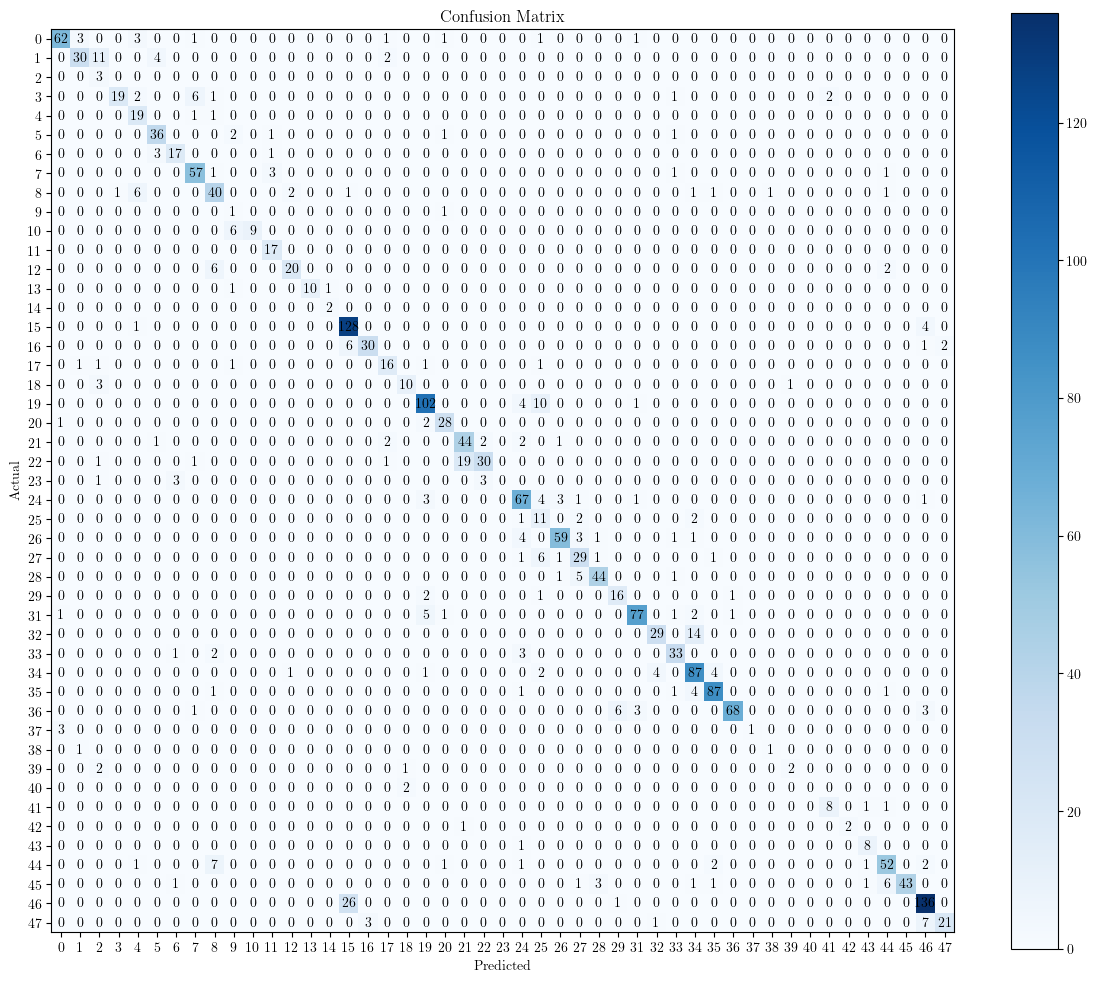

In [12]:
confusion_matrix_before, labels = stats.confusion_matrix(130, run_id1, 'test')
viz.plot_confusion_matrix(confusion_matrix_before, labels=labels)

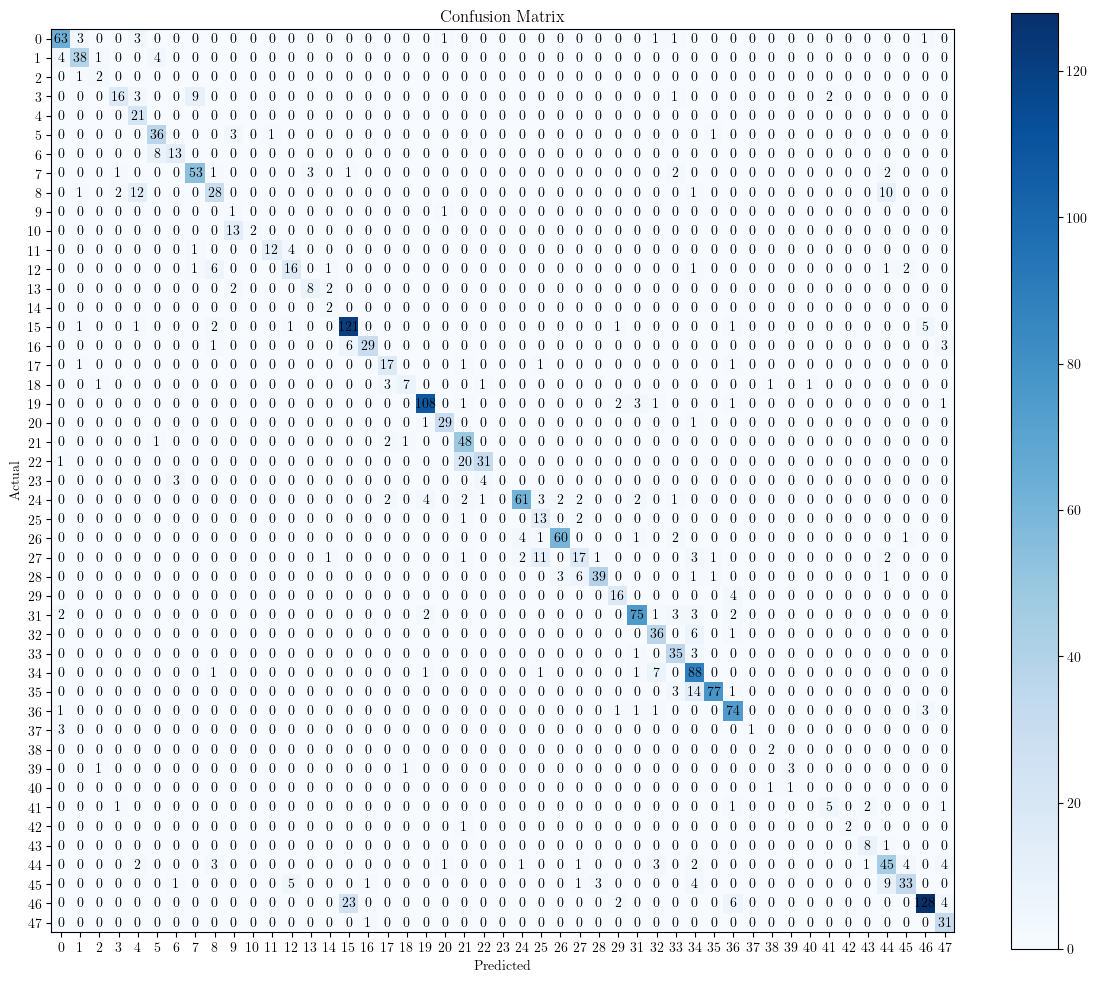

In [13]:
confusion_matrix_after, labels = stats.confusion_matrix(190, run_id2, 'test')
viz.plot_confusion_matrix(confusion_matrix_after, labels=labels)

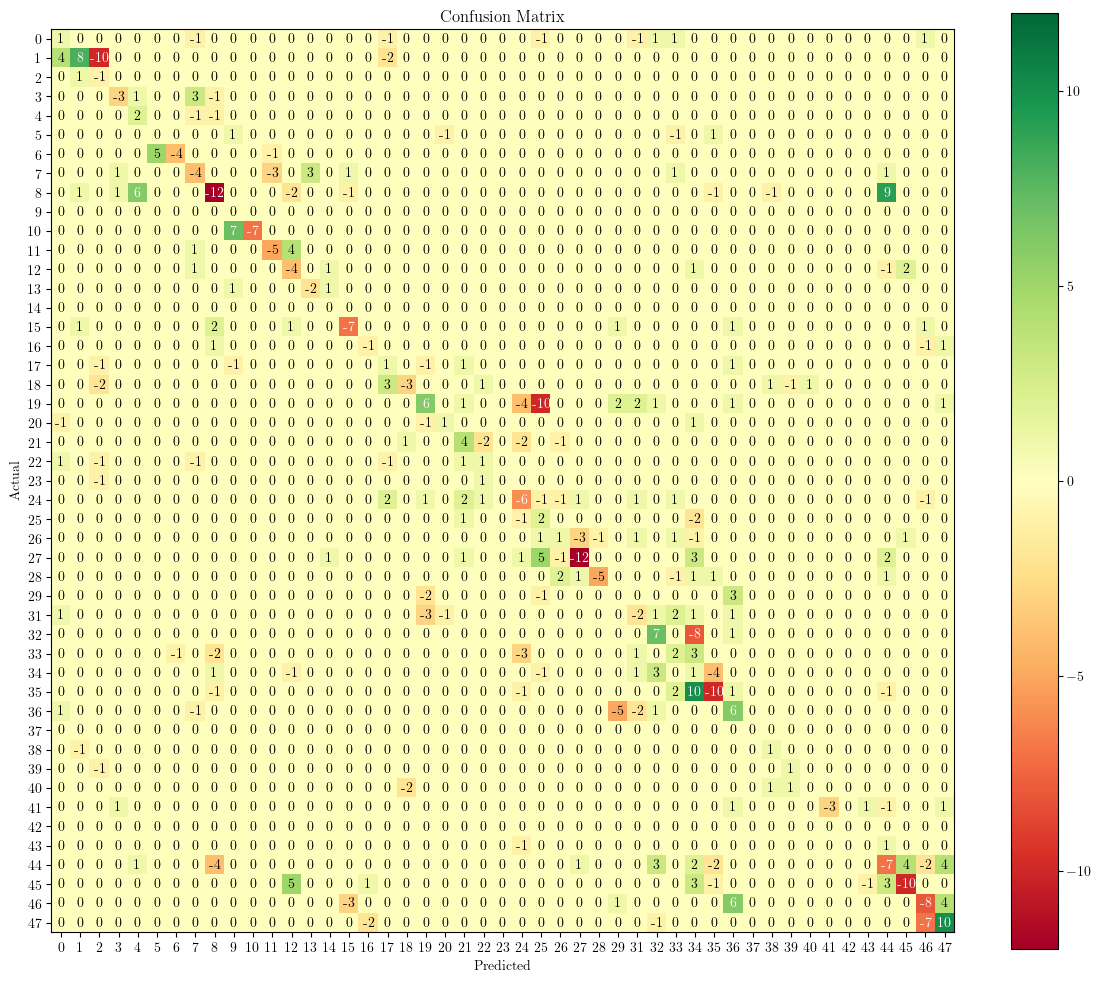

In [21]:
def plot_confusion_matrix(confusion_matrix, save_path=None, labels=None, **_kwargs):
    if labels is None:
        labels = np.arange(len(confusion_matrix))

    cmap = plt.cm.RdYlGn  # Using built-in Red-Yellow-Green colormap

    # Visualizing the confusion matrix using matplotlib
    plt.figure(figsize=(12, 10))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap, vmin=-12, vmax=12)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(len(confusion_matrix)), labels=labels)
    plt.yticks(np.arange(len(confusion_matrix)), labels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Adding text annotations for each cell
    for i in range(len(confusion_matrix)):
        for j in range(len(confusion_matrix[i])):
            plt.text(j, i, format(confusion_matrix[i][j], 'd'),
                     ha="center", va="center",
                     color="black" if abs(confusion_matrix[i][j]) < np.max(np.abs(confusion_matrix)) / 2 else "white")

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


confusion_matrix_change = confusion_matrix_after - confusion_matrix_before
plot_confusion_matrix(confusion_matrix_change, save_path='confusion_matric_egl_change.png', labels=labels)